In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [70]:
data = pd.read_csv("train.csv")

In [71]:
data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [72]:
data['CentralAir'].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

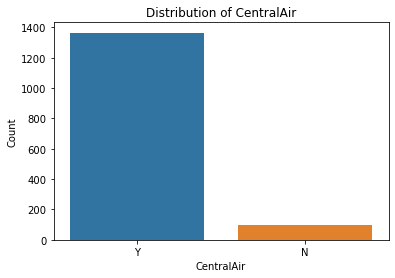

In [73]:
sns.countplot(x='CentralAir', data=data)
plt.title('Distribution of CentralAir')
plt.xlabel('CentralAir')
plt.ylabel('Count')
plt.show()

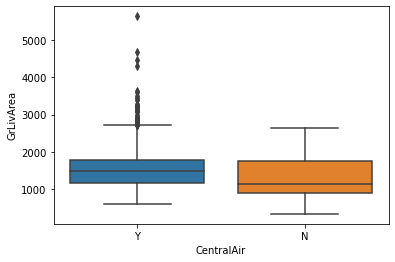

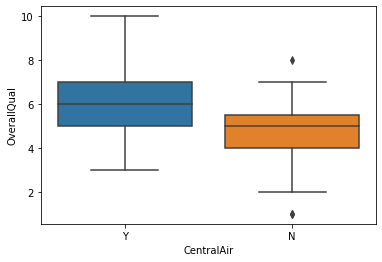

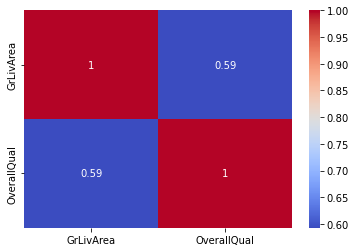

In [74]:
sns.boxplot(data=data, x="CentralAir", y="GrLivArea")
plt.show()

sns.boxplot(data=data, x="CentralAir", y="OverallQual")
plt.show()

corr = data[["GrLivArea", "OverallQual"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [75]:
data["CentralAir_bin"] = data["CentralAir"].map({"Y": 1, "N": 0})

In [76]:
data["CentralAir_bin"].value_counts()

1    1365
0      95
Name: CentralAir_bin, dtype: int64

In [77]:
data["CentralAir_bin"]

0       1
1       1
2       1
3       1
4       1
       ..
1455    1
1456    1
1457    1
1458    1
1459    1
Name: CentralAir_bin, Length: 1460, dtype: int64

In [78]:
print("Missing values in predictors:")
print(data[['GrLivArea', 'OverallQual']].isnull().sum())

Missing values in predictors:
GrLivArea      0
OverallQual    0
dtype: int64


In [79]:
X = data[['GrLivArea', 'OverallQual']]
y = data['CentralAir_bin']

X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.196362
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         CentralAir_bin   No. Observations:                 1460
Model:                          Logit   Df Residuals:                     1457
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Dec 2025   Pseudo R-squ.:                  0.1842
Time:                        09:35:48   Log-Likelihood:                -286.69
converged:                       True   LL-Null:                       -351.41
Covariance Type:            nonrobust   LLR p-value:                 7.793e-29
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.5008      0.535     -4.671      0.000      -3.550      -1.451
GrLivArea      -0.0007    

In [80]:
p_values = model.pvalues
print("P-values of the coefficients:")
print(p_values)

P-values of the coefficients:
const          2.995191e-06
GrLivArea      6.074883e-03
OverallQual    7.731931e-22
dtype: float64


In [81]:
if p_values['GrLivArea'] < 0.05:
    print("'GrLivArea' is statistically significant at the 5% level.")
else:
    print("'GrLivArea' is not statistically significant at the 5% level.")

'GrLivArea' is statistically significant at the 5% level.


In [82]:
odds_ratios = np.exp(model.params)
print(odds_ratios)

const          0.082023
GrLivArea      0.999255
OverallQual    3.157930
dtype: float64


In [83]:
X = data[['GrLivArea', 'OverallQual']]
y = data['CentralAir_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [84]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train).fit()

y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob >= 0.5).astype(int)

tp = np.sum((y_test == 1) & (y_pred == 1))
tn = np.sum((y_test == 0) & (y_pred == 0))
fp = np.sum((y_test == 0) & (y_pred == 1))
fn = np.sum((y_test == 1) & (y_pred == 0))

print("Confusion Matrix:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

Optimization terminated successfully.
         Current function value: 0.199981
         Iterations 8
Confusion Matrix:
True Positives (TP): 273
True Negatives (TN): 2
False Positives (FP): 17
False Negatives (FN): 0


In [85]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9417808219178082


In [86]:
def compute_roc(y_test, y_pred_prob):
    tpr = []
    fpr = []
    thresholds = np.linspace(0, 1, 50)
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        tp = np.sum((y_test == 1) & (y_pred == 1))
        tn = np.sum((y_test == 0) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        fn = np.sum((y_test == 1) & (y_pred == 0))
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return tpr, fpr, threshold

In [87]:
results = compute_roc(y_test, y_pred_prob)
print(results)

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9926739926739927, 0.9853479853479854, 0.9706959706959707, 0.9633699633699634, 0.9377289377289377, 0.9340659340659341, 0.9304029304029304, 0.8974358974358975, 0.8681318681318682, 0.7619047619047619, 0.6373626373626373, 0.575091575091575, 0.34798534798534797, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8421

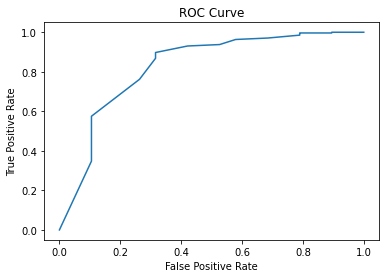

In [88]:
plt.plot(results[1], results[0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

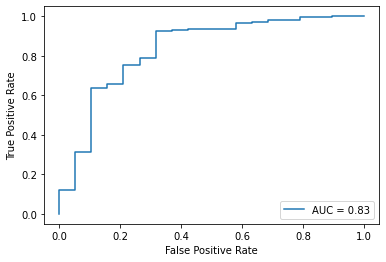

In [90]:
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [91]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(skf.get_n_splits(X, y))

fold_train = X_train.iloc[list(skf.split(X_train, y_train))[0][0]]

fold_validation = X_train.iloc[list(skf.split(X_train, y_train))[0][1]]
print(fold_train.shape)
print(fold_validation.shape)

5
(934, 3)
(234, 3)
